In [168]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy import sparse
from scipy.sparse import diags
from scipy.sparse.linalg import factorized
from PIL import Image

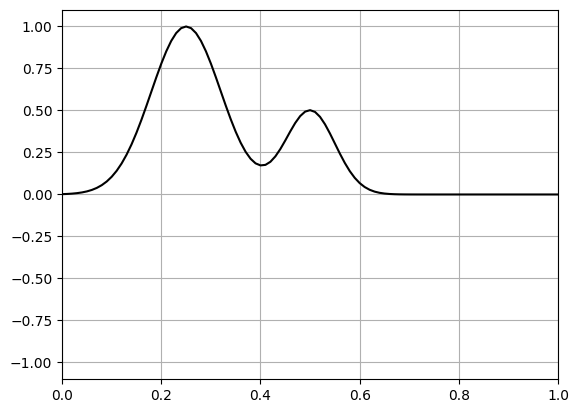

In [169]:
L = 1
T = 10

dx = 1e-2
dt = 1e-3

x = np.arange(0, L+dx, dx)
t = np.arange(0, T+dt, dt)

Nt, Nx = len(t), len(x)

def u0(x):
    return np.exp(-100*(x-L/4)**2) + np.exp(-200*(x-L/2)**2)*0.5

fig, ax = plt.subplots()
ax.plot(x, u0(x), color="black", lw=1.5)
ax.set_xlim(0, L)
ax.set_ylim(-1.1, 1.1)
ax.grid()


In [170]:
def save_gif_PIL(outfile, files, fps=5, loop=0):
    "Helper function for saving GIFs"
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=round(1000/fps), loop=loop)

def make_plot(save=False, file_name=f"PDE_solution.png", ti=0):
    "Helper function for plotting"
    fig, ax = plt.subplots()
    ax.plot(x, u[i, :], color="black", lw=1.5)
    ax.set_xlim(0, L)
    ax.set_ylim(-1.1, 1.1)
    ax.grid()
    ax.set_title(f"Time = {ti:.3f}s")
    if save:
        fig.savefig(file_name, bbox_inches="tight", pad_inches=0.1, dpi=100, facecolor="white")

In [171]:
def D_t():
    D = 1/(12*dx) * diags([1, -8, 0, 8, -1], [-2, -1, 0, 1, 2], shape=(Nx, Nx)).toarray()
    D[0, [-2, -1]] = [1*1/(12*dx), -8*1/(12*dx)]
    D[1, [-1]] = [1*1/(12*dx)]
    D[-1, [0, 1]] = [8*1/(12*dx), -1*1/(12*dx)]
    D[-2, [0]] = [-1*1/(12*dx)]
    return sparse.csr_matrix(D)

def D2_t():
    D = 1/(dx**2) * diags([-1, 16, -30, 16, -1], [-2, -1, 0, 1, 2], shape=(Nx, Nx)).toarray()
    D[0, [-2, -1]] = [-1/(dx**2), 16/(dx**2)]
    D[1, [-1]] = [-1/(dx**2)]
    D[-1, [0, 1]] = [16/(dx**2), -1/(dx**2)]
    D[-2, [0, 1]] = [-1/(dx**2)]
    return sparse.csr_matrix(D)

u  = np.zeros((Nt, Nx))
c  = 5e-1
a  = 1e-4
D1 = D_t()
D2 = D2_t()

def sovler_implicit(ui, uj):
    res = ui - uj + dt*0.5*(c*np.diag(ui)@(D1@ui) + c*np.diag(uj)@(D1@uj) - a*(D2@ui) - a*(D2@uj))
    return res.flatten()

In [172]:
for i, ti in enumerate(t):
    if i == 0:
        u[0, :] = u0(x)
    else:
        try:
            uj      = u[i-1, :]
            u[i, :] = fsolve(sovler_implicit, uj, args=(uj), xtol=1e-4)
        except Exception as e:
            print(f"fsolve failed at time step {i}: {e}")
            break
    
    if i % int(1/dt * 1e-1) == 0:
        print(f"Time {ti:.3f}s, max u = {np.max(np.abs(u[i, :])):.3f}")


Time 0.000s, max u = 1.000
Time 0.100s, max u = 0.976
Time 0.200s, max u = 0.954
Time 0.300s, max u = 0.927
Time 0.400s, max u = 0.898
Time 0.500s, max u = 0.865
Time 0.600s, max u = 0.833
Time 0.700s, max u = 0.806
Time 0.800s, max u = 0.780
Time 0.900s, max u = 0.759
Time 1.000s, max u = 0.741
Time 1.100s, max u = 0.724
Time 1.200s, max u = 0.710
Time 1.300s, max u = 0.697
Time 1.400s, max u = 0.684
Time 1.500s, max u = 0.670
Time 1.600s, max u = 0.656
Time 1.700s, max u = 0.641
Time 1.800s, max u = 0.625
Time 1.900s, max u = 0.612
Time 2.000s, max u = 0.599
Time 2.100s, max u = 0.587
Time 2.200s, max u = 0.574
Time 2.300s, max u = 0.563
Time 2.400s, max u = 0.552
Time 2.500s, max u = 0.543
Time 2.600s, max u = 0.533
Time 2.700s, max u = 0.523
Time 2.800s, max u = 0.515
Time 2.900s, max u = 0.507
Time 3.000s, max u = 0.499
Time 3.100s, max u = 0.491
Time 3.200s, max u = 0.485
Time 3.300s, max u = 0.478
Time 3.400s, max u = 0.471
Time 3.500s, max u = 0.464
Time 3.600s, max u = 0.453
T

In [175]:
import os
import shutil

folder_path="plots"
for item in os.listdir(folder_path):
    item_path = os.path.join(folder_path, item)
    try:
        if os.path.isfile(item_path) or os.path.islink(item_path):
            os.unlink(item_path)  # Remove file or symbolic link
        elif os.path.isdir(item_path):
            shutil.rmtree(item_path)  # Remove subdirectory and its contents
    except Exception as e:
        print(f"Failed to delete {item_path}. Reason: {e}")

In [176]:
files = []
fps   = 20
frame_indicies = np.linspace(0, Nt-1, int(fps*T*2), dtype=int)
for i in frame_indicies:
    ti = t[i]
    file = f"plots/PDE_sol_{ti:.5f}.png"
    make_plot(save=True, file_name=file, ti=ti)
    files.append(file)
    plt.close("all")
    
save_gif_PIL("PDE_solution.gif", files, fps=fps, loop=0)